## Using a GAT neural surrogate of potency

Instantiate model structure.

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import dgym as dg
from dgym.envs import oracle

config = {
    "dropout": 0.05,
    "gnn_hidden_feats": 64,
    "num_heads": 8,
    "alpha": 0.06,
    "predictor_hidden_feats": 128,
    "num_gnn_layers": 5,
    "residual": True
}

model = oracle.build_model_2d(config=config)

Load state dict from disk.

In [3]:
root_dir = '../../dgym-data/neural/'
file_name = 'asapdiscovery-SARS-CoV-2-Mpro-GAT-2023.08.25.th'
path = f'{root_dir}/{file_name}'

preloaded_state_dict = torch.load(path)
state_dict = dict(zip(
    model.state_dict().keys(),
    preloaded_state_dict.values()
))

model.load_state_dict(state_dict)
model.eval()
model = model.to(device)

Import data.

In [5]:
import dgym as dg

deck = dg.MoleculeCollection.from_sdf(
    # f'{root_dir}/DSi-Poised_Library_annotated.sdf',
    f'{root_dir}/Mpro_combined_aminopyridine.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

Try predicting.

In [48]:
import pandas as pd
import dgl
import dgllife

def predict(molecules):
    
    # make mol_to_graph util
    mol_to_graph = dgllife.utils.MolToBigraph(
        add_self_loop=True,
        node_featurizer=dgllife.utils.CanonicalAtomFeaturizer()
    )

    # featurize
    graphs = [
        mol_to_graph(m.update_cache().mol)
        for m in molecules
    ]

    # batch
    graph_batch = dgl.batch(graphs).to(device)

    # perform inference
    with torch.no_grad():
        preds = model({'g': graph_batch})
    
    return preds.ravel().tolist()

preds = predict(deck)

# convert to dataframe
aff_pred = pd.DataFrame.from_dict({
    'smiles': deck.smiles,
    'pIC50_pred': preds}
)

Comparing to actuals.

In [160]:
import pandas as pd

# import data
aff_actual = pd.read_csv(f'{root_dir}/CDD CSV Export - 2023-09-11 11h31m13s.csv')
aff_actual = aff_actual[[
    'suspected_SMILES',
    'Canonical PostEra ID',
    'ProteaseAssay_Fluorescence_Dose-Response_Weizmann: IC50 (µM)'
]].copy()
aff_actual.columns = ['smiles', 'compound_id', 'IC50']

# convert affinity to numeric
aff_actual = aff_actual.dropna(subset='IC50')
aff_actual['IC50'] = pd.to_numeric(aff_actual['IC50'], errors='coerce').fillna(99.5)

# transform to pIC50
import numpy as np
aff_actual['pIC50'] = -np.log10(aff_actual['IC50'] * 1e-6)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


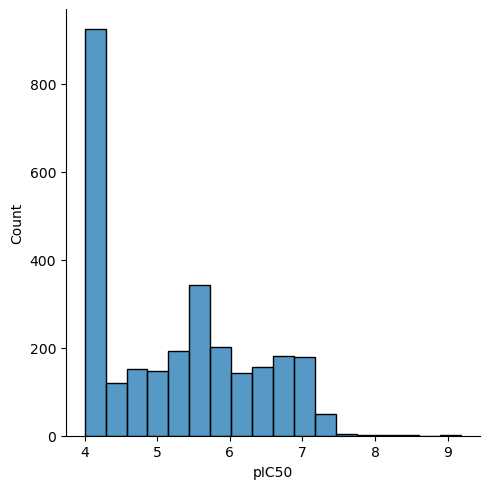

In [163]:
sns.displot(
    aff_actual['pIC50']
)

In [125]:
from dgym.molecule import Molecule
from dgym.collection import Collection

# create collection
data = Collection([
    Molecule(Chem.MolFromSmiles(s)) for s in aff_actual['smiles']
])

aff_actual['pIC50_pred'] = np.clip(predict(data), 4, np.inf)

Quantitative metrics.

In [142]:
from rdkit import Chem
from dgym.molecule import Molecule
from dgym.collection import Collection

import json

# import data
data = json.load(open('../../dgym-data/neural/test.table.json'))
train = pd.DataFrame(data['data'], columns=data['columns'])

# merge with affinities
aff = aff_actual.merge(train, on='compound_id')

# create collection
data = Collection([
    Molecule(Chem.MolFromSmiles(s)) for s in aff['smiles']
])

# predict
aff['pIC50_pred'] = np.clip(predict(data), 4, np.inf)

In [143]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

print('Pearson r:\t', pearsonr(aff['pIC50_y'], aff['pIC50_pred']).statistic)
print('RMSE:\t\t', mean_squared_error(aff['pIC50_y'], aff['pIC50_pred'], squared=False))

Pearson r:	 0.8258321388319217
RMSE:		 0.7684321318984335


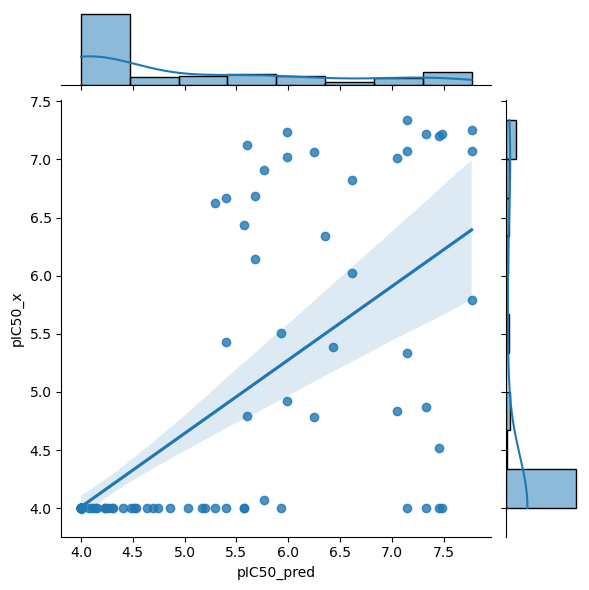

In [158]:
import seaborn as sns

sns.jointplot(
    data=aff,
    x='pIC50_pred',
    y='pIC50_x',
    kind="scatter"
)